In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt',
       'Price', 'state_Rural', 'state_Suburb', 'state_Urban'],
      dtype='object')
[0, 1]


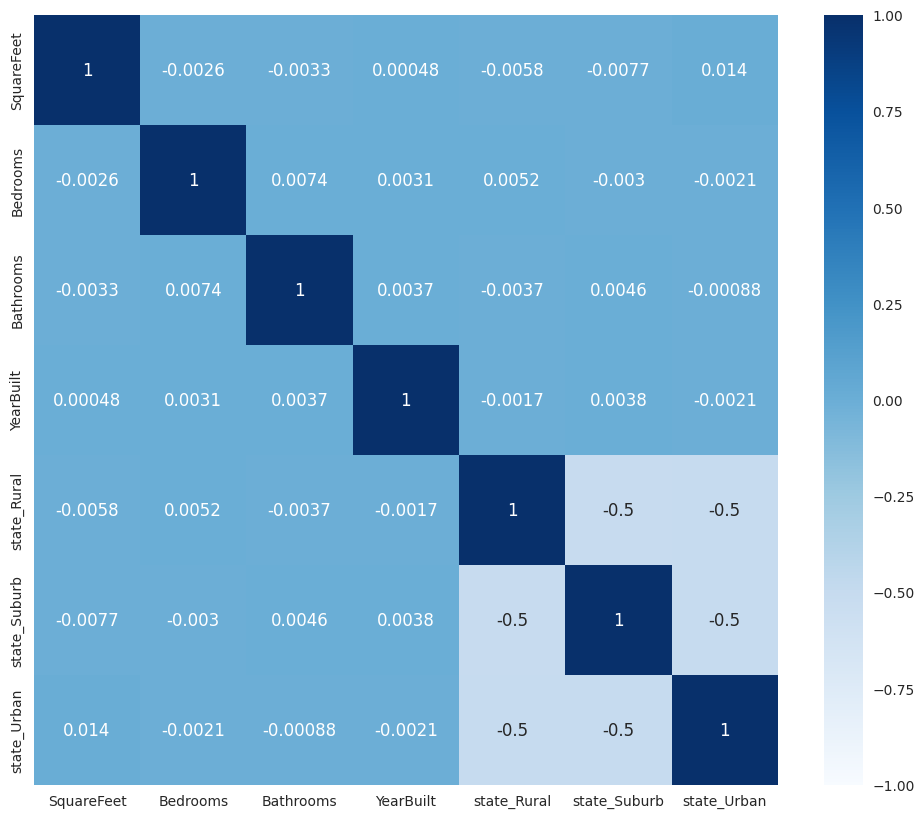

0: 0
1: 0
Price
0    30923
1    30923
Name: count, dtype: int64


In [1]:
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport

N_COLS= 3
N_ROWS = 3




#comp_dir = Path('dataset\\')
data = pd.read_csv(
    "/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv",
    usecols=['SquareFeet','Bedrooms','Bathrooms','Neighborhood','YearBuilt','Price'],
    dtype={
        'SquareFeet': 'int',
        'Price': 'float32',
        'YearBuilt': 'int',
        'Bedrooms': 'int',
        'Bathrooms': 'int',
        'Neighborhood': 'category',
    },
)
# data['Neighborhood'] = data['Neighborhood'].replace(['Rural', 'Suburb'], 'Non Urban')



# = = = dummy features generation = = =
dummies = pd.get_dummies(data['Neighborhood'], prefix='state')
# Concatenate the dummy features with the original DataFrame
data = pd.concat([data, dummies], axis=1)

print(data.columns)
#bins = [-float('inf'), 200000, 300000, 400000, float('inf')]  # Adjust the bin edges as needed
#labels = ['<200k', '<300k', '<400k', 'over']
bins = [-float('inf'), 250000, float('inf')]
labels = [0, 1]
print(labels)

data['Price'] = pd.cut(data['Price'], bins=bins, labels=labels, right=False)
y = data['Price']                # predicted variable
X = data.drop(['Neighborhood', 'Price'], axis=1)

plt.figure(figsize=(12,10))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
plt.show()


# = = = Data Normalization = = =
scaler = MinMaxScaler()
X[['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt']] = \
    scaler.fit_transform(X[['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt']])

#  = = = Rilevamento imbalance = = =
a = []
for lab in labels:
    a.append(data.query(f"Price == '{lab}'").shape[0])
    print(f"{lab}: {a[-1]}")


# = = = Balancing = = =

# classi bilanciate, non è servito
oversampler = SMOTE()
X, y = oversampler.fit_resample(X, y)

print(y.value_counts())


rs = 42 # Random state var
# Split the data to check which algorithms learn better (later on we can check )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

classifiers = [
    DecisionTreeClassifier(random_state=rs),                    # rischio verfitting, buoni con non linearity
    RandomForestClassifier(n_estimators = 10, random_state=rs), # meno overfitting, piu generalizzazione
 #   MLPClassifier(random_state=rs),  # soluzione deep = complessa e richiede tanti dati e costosa
    GradientBoostingClassifier(random_state=rs),  # basata su alberi -> xgboost
    #LogisticRegression(random_state=rs),  # binary....
    # SVC(probability=True),  # hi-dim e classi con bordo netto -> non il nostro caso anche per che non finisce mai
    #GaussianNB(),  # si usano in casi più complessi, penso
    #LinearDiscriminantAnalysis(),  # linear decision boundary.
    #AdaBoostClassifier((DecisionTreeClassifier(random_state=rs)), random_state=rs, learning_rate=0.1),
    # ADA combina i risultati di più weak learner, serve per generalizzare(quindi no noisy data o outliers)
];



Accuracy: 0.75 	 ---> DecisionTreeClassifier 
Accuracy: 0.8 	 ---> RandomForestClassifier 
Accuracy: 0.81 	 ---> GradientBoostingClassifier 
[0.7399345103366501, 0.7908278030061252, 0.8073813343020495]

[0.005550600987927776, 0.005617726993418542, 0.005366868756351218]



<Figure size 1200x1000 with 0 Axes>

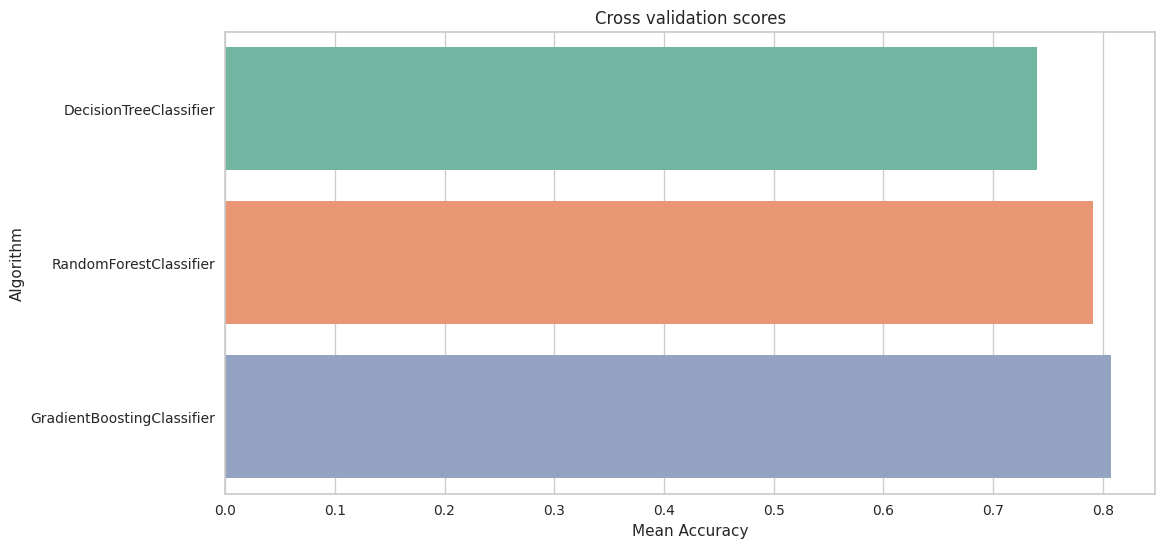

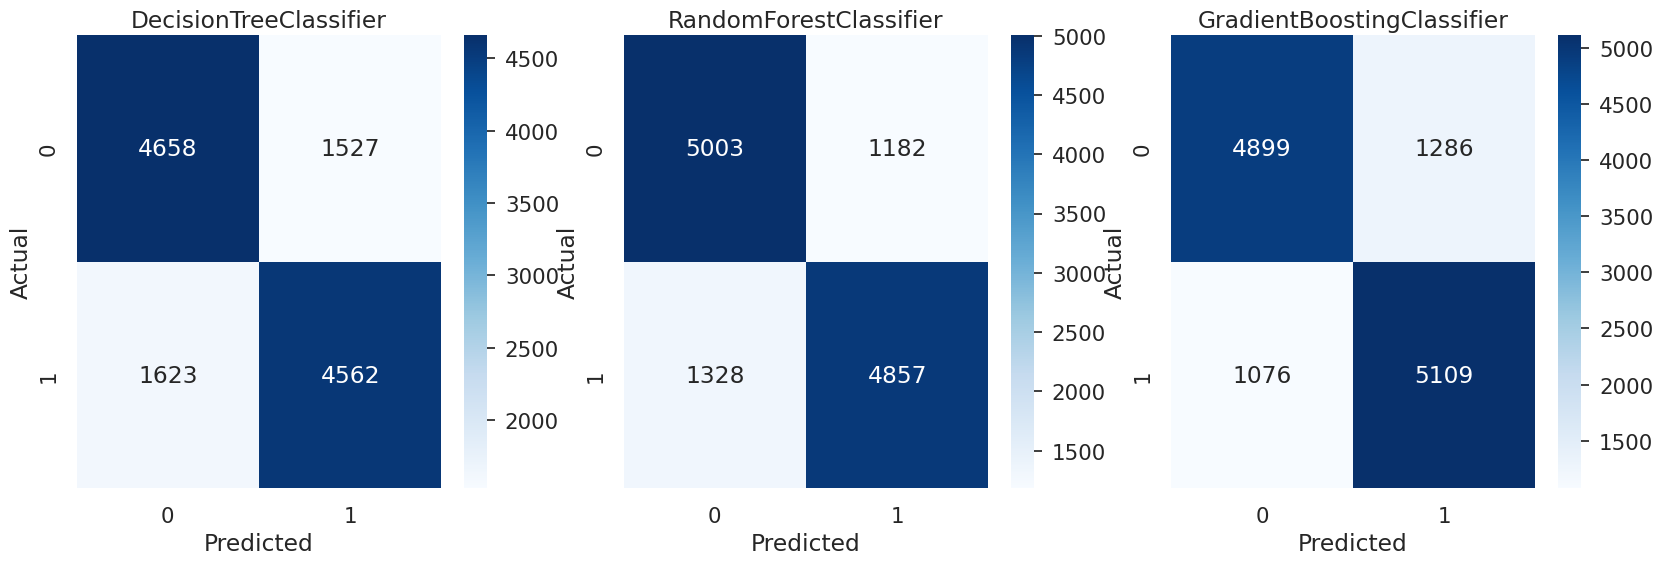

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      6185
           1       0.75      0.74      0.74      6185

    accuracy                           0.75     12370
   macro avg       0.75      0.75      0.75     12370
weighted avg       0.75      0.75      0.75     12370

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      6185
           1       0.80      0.79      0.79      6185

    accuracy                           0.80     12370
   macro avg       0.80      0.80      0.80     12370
weighted avg       0.80      0.80      0.80     12370

GradientBoostingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      6185
           1       0.80      0.83      0.81      6185

    accuracy                           0

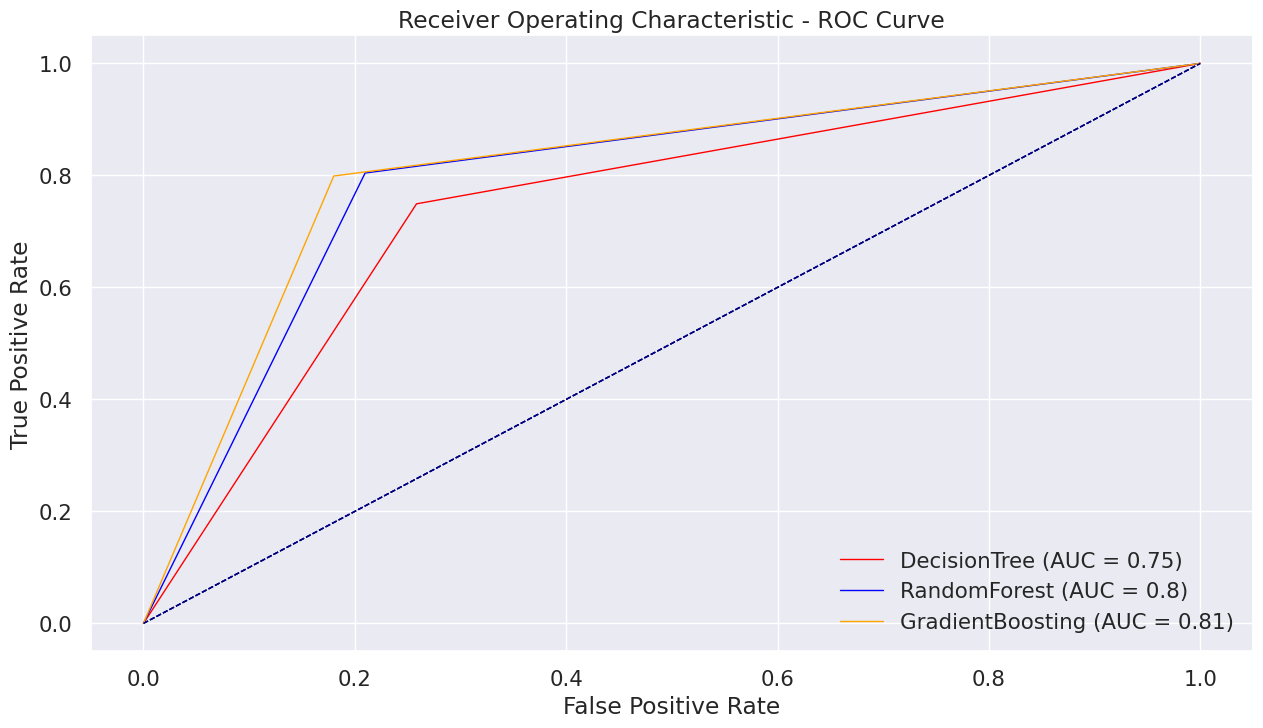

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

score without GridSearchCV:  0.74 0.791 0.807
score with GridSearchCV:  0.804 0.812 0.811
---end---


In [2]:
clf_name = [] # nomi classifiers
model_results = pd.DataFrame.copy(y_test)

kfold = StratifiedKFold(n_splits=10) # cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimize

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = []
roc_tpr = []
roc_fpr = []

plt.figure(figsize=(12,10))
#fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
# Training the algorithms and results
for classifier in classifiers:
    name = classifier.__class__.__name__
    clf_name.append(name)

    # fitting and predictions
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_results[name] = y_pred

    # accuracy and log loss
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring="accuracy", cv=kfold))
    acc = round(accuracy_score(y_test, y_pred), 2)  # need to maximize
    y_score = classifier.predict_proba(X_test)
    print(f'Accuracy: {acc} \t ---> {name} ')

    # confusion matrix, classification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))               #NOTA: not ok for multiplae
    clr.append(classification_report(y_test, y_pred))

    # - ROC AUC -
    #plot_roc_one_v_one(name, labels, y_test, y_score)
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)



for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

print(cv_acc)
print()
print(cv_std)
print()

# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h") #,**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()

# - - - Confusion matrixes (non normalized) - - -
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(N_ROWS, N_COLS, i+1)
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])
plt.show()



# - - - Classification report - - -
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])
print()


# ROC Curve
# moved to function plot_roc... per OvO

plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ROC Curve')
    plt.legend(loc="lower right")
plt.show()


# ... continua

#grid search
# Search grid for optimal parameters


DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

"""
MLP_param = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive']}
"""

GB_param = {'loss' : ["deviance"],
            'n_estimators' : [100,200,300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 8],
            'min_samples_leaf': [100,150],
            'max_features': [0.3, 0.1]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
#MLPgs = GridSearchCV(MLPClassifier(), param_grid=MLP_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
GBgs = GridSearchCV(GradientBoostingClassifier(), param_grid=GB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs, GBgs]

gs_model = []
score = []

for model in models:
    model.fit(X_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[0], 3), round(cv_acc[1], 3), round(cv_acc[2], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3), round(score[2], 3),)



print("---end---")


In [8]:
print(model_results[['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']])
df = pd.DataFrame(model_results[['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']].tolist(), index=model_results[['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']].index).T
print(df)


DecisionTreeClassifier        [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, ...
RandomForestClassifier        [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...
GradientBoostingClassifier    [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...
Name: Price, dtype: object
       DecisionTreeClassifier  RandomForestClassifier  \
0                           1                       1   
1                           0                       0   
2                           1                       1   
3                           1                       1   
4                           0                       0   
...                       ...                     ...   
12365                       0                       0   
12366                       0                       0   
12367                       0                       0   
12368                       1                       1   
12369                       1                       1   

       GradientBoostingClassifier  
0           

Text(0.5, 1.0, 'Correlation between models')

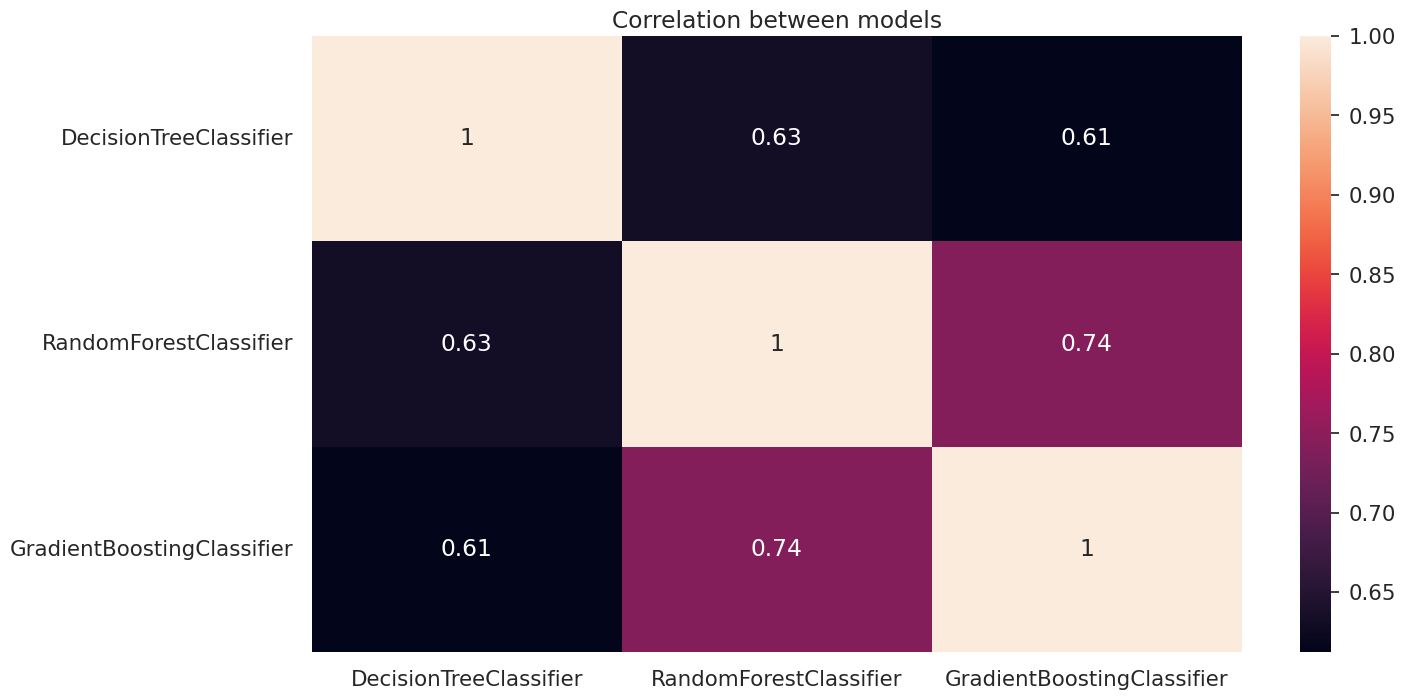

In [9]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation between models")

In [5]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1]),
    ('gb', gs_model[2])], voting='soft', n_jobs=4)
best_model.fit(X_train,y_train)
print(accuracy_score(y_test,best_model.predict(X_test)))

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.812287793047696


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


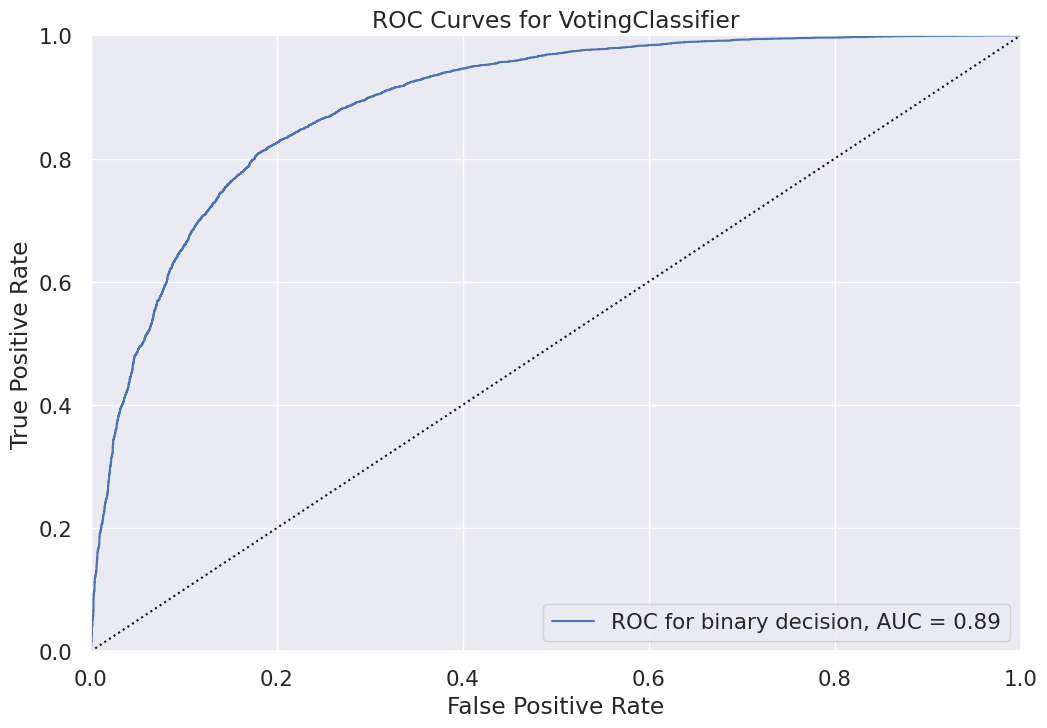

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


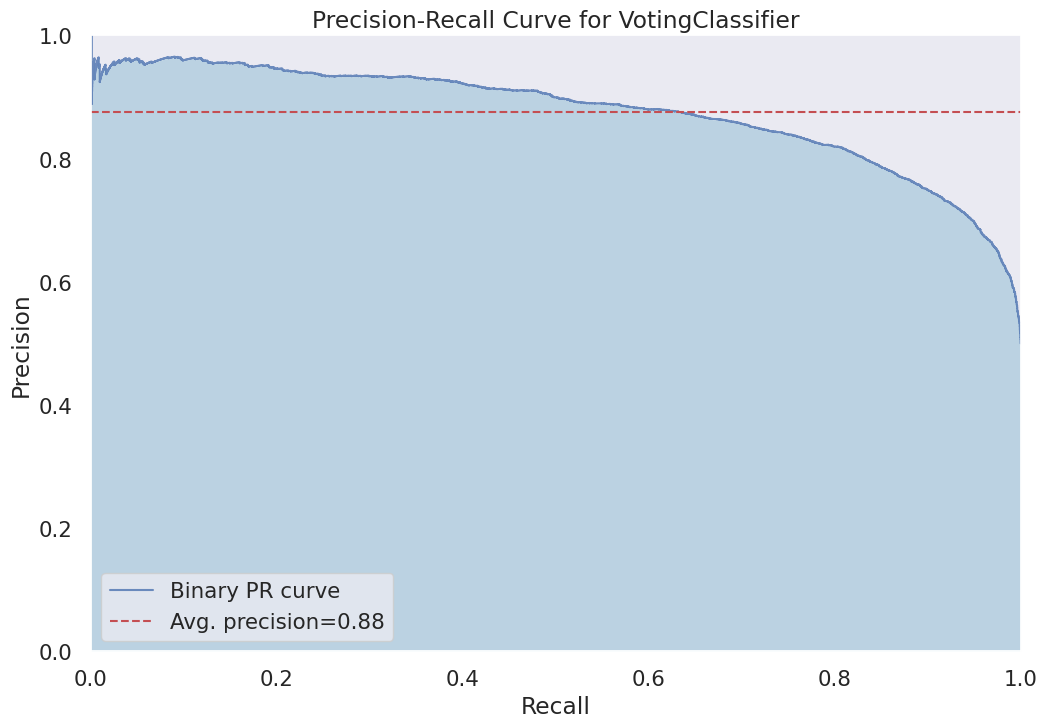

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

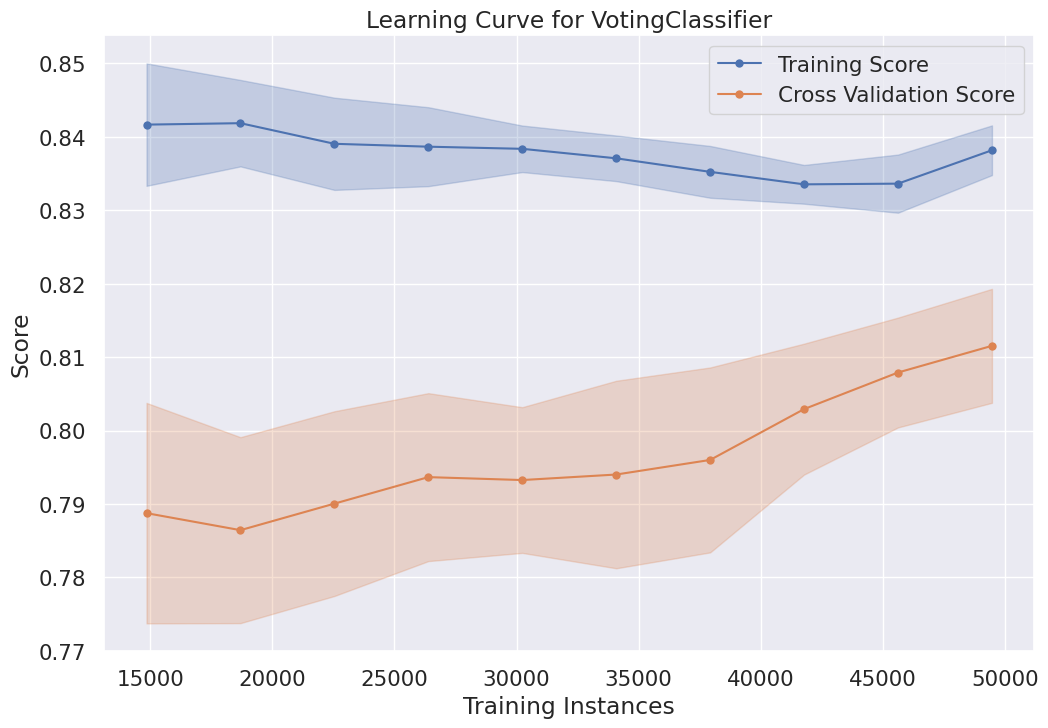

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [7]:
#=====================================================================================================================#

from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=labels, micro=False, macro=False, binary=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure
